In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

**Note:**

- The dataset is imbalanced.
- Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
- Missing imputation can be a part of your pipeline as well.

**Features:**

- enrollee_id : Unique ID for candidate
- city: City code
- city_ development _index : Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline :Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

**Inspiration:**

- Predict the probability of a candidate will work for the company
- Interpret model(s) such a way that illustrate which features affect candidate decision

# Load and check data.

In [3]:
train_data = pd.read_csv('aug_train.csv')
test_data = pd.read_csv('aug_test.csv')
sub_data = pd.read_csv('sample_submission.csv')

In [4]:
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
test_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [6]:
sub_data.head()

,enrollee_id,target
0,32403,0.5
1,9858,0.5
2,31806,0.5
3,27385,0.5
4,27724,0.5


In [7]:
print("train data shape =", train_data.shape)
print("test data shape =", test_data.shape)
print("submission data shape =", sub_data.shape)

train data shape = (19158, 14)
test data shape = (2129, 13)
submission data shape = (2129, 2)


# Let's see how much missed data we have...

In [8]:
train_data.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Wow! 

In [9]:
test_data.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [10]:
sub_data.isnull().sum()

enrollee_id    0
target         0
dtype: int64

In [11]:
cols = train_data.columns[0:14]
for col in cols:
    print(train_data[col].unique())

[ 8949 29725 11561 ... 24576  5756 23834]
['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77'

# Some methods to find duplicates.

In [12]:
print(train_data['enrollee_id'].equals(test_data['enrollee_id']))
print(train_data['enrollee_id'].equals(sub_data['enrollee_id']))
print(test_data['enrollee_id'].equals(sub_data['enrollee_id']))
print((test_data['enrollee_id'] == sub_data['enrollee_id']).all())

False
False
True
True


In [13]:
set(train_data['enrollee_id']) & set(test_data['enrollee_id'])

set()

**Yes, we have no duplicates. Thx lord!**

# Replace nan values

In [15]:
cols_train = train_data.columns[2:14]
for col in cols_train:
    train_data[col] = train_data[col].fillna("No_Answer")
    
cols_test = test_data.columns[2:13]
for col in cols_test:
    test_data[col] = test_data[col].fillna("No_Answer")

In [16]:
cols = train_data.columns[2:14]
for col in cols:
    print(train_data[col].unique())

[0.92  0.776 0.624 0.789 0.767 0.764 0.762 0.913 0.926 0.827 0.843 0.804
 0.855 0.887 0.91  0.884 0.924 0.666 0.558 0.923 0.794 0.754 0.939 0.55
 0.865 0.698 0.893 0.796 0.866 0.682 0.802 0.579 0.878 0.897 0.949 0.925
 0.896 0.836 0.693 0.769 0.775 0.903 0.555 0.727 0.64  0.516 0.743 0.899
 0.915 0.689 0.895 0.89  0.847 0.527 0.766 0.738 0.647 0.795 0.74  0.701
 0.493 0.84  0.691 0.735 0.742 0.479 0.722 0.921 0.848 0.856 0.898 0.83
 0.73  0.68  0.725 0.556 0.448 0.763 0.745 0.645 0.788 0.78  0.512 0.739
 0.563 0.518 0.824 0.487 0.649 0.781 0.625 0.807 0.664]
['Male' 'No_Answer' 'Female' 'Other']
['Has relevent experience' 'No relevent experience']
['no_enrollment' 'Full time course' 'No_Answer' 'Part time course']
['Graduate' 'Masters' 'High School' 'No_Answer' 'Phd' 'Primary School']
['STEM' 'Business Degree' 'No_Answer' 'Arts' 'Humanities' 'No Major'
 'Other']
['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' 'No_Answer']
['No_Ans

In [17]:
cols = test_data.columns[2:13]
for col in cols:
    print(test_data[col].unique())

[0.827 0.92  0.624 0.899 0.878 0.698 0.762 0.949 0.722 0.926 0.754 0.743
 0.91  0.903 0.913 0.897 0.89  0.924 0.939 0.689 0.794 0.923 0.925 0.666
 0.807 0.682 0.55  0.74  0.887 0.855 0.745 0.558 0.487 0.848 0.884 0.915
 0.856 0.725 0.579 0.764 0.556 0.921 0.866 0.767 0.893 0.518 0.527 0.898
 0.804 0.802 0.895 0.776 0.738 0.512 0.896 0.789 0.83  0.843 0.847 0.795
 0.664 0.766 0.836 0.727 0.448 0.691 0.493 0.479 0.693 0.763 0.516 0.742
 0.865 0.781 0.788 0.796 0.64  0.563 0.84  0.769 0.555]
['Male' 'Female' 'No_Answer' 'Other']
['Has relevent experience' 'No relevent experience']
['Full time course' 'no_enrollment' 'Part time course' 'No_Answer']
['Graduate' 'High School' 'Masters' 'No_Answer' 'Phd' 'Primary School']
['STEM' 'No_Answer' 'Other' 'Business Degree' 'Arts' 'Humanities'
 'No Major']
['9' '5' '<1' '11' '>20' '10' '14' '3' '20' '8' '4' '13' '2' '6' '7' '1'
 '19' '15' '16' 'No_Answer' '17' '18' '12']
['<10' 'No_Answer' '10/49' '10000+' '100-500' '50-99' '1000-4999'
 '500-999' '5

<AxesSubplot:xlabel='gender', ylabel='count'>

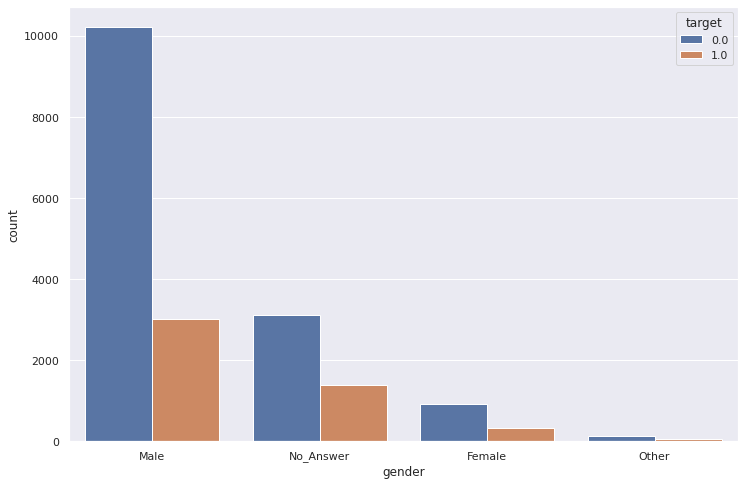

In [18]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train_data['gender'], hue='target', data=train_data)

**We see that males are more workers then females)**

**We have not so big disblance in class.**

<AxesSubplot:xlabel='major_discipline', ylabel='count'>

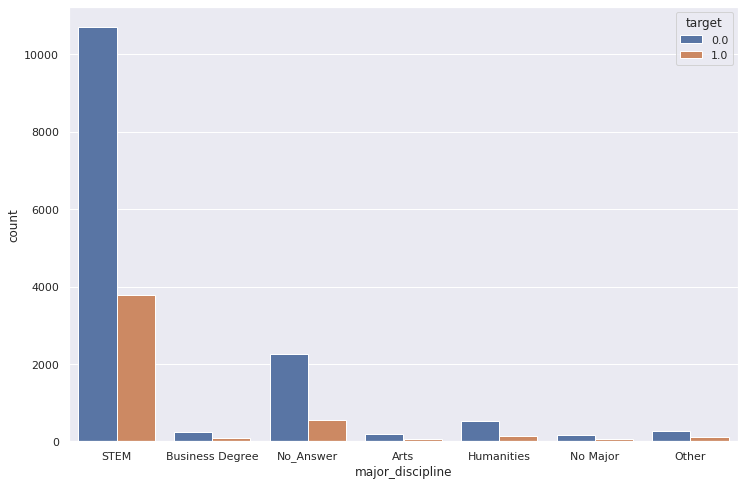

In [19]:
sns.countplot(x=train_data['major_discipline'], hue='target', data=train_data)

<AxesSubplot:xlabel='relevent_experience', ylabel='count'>

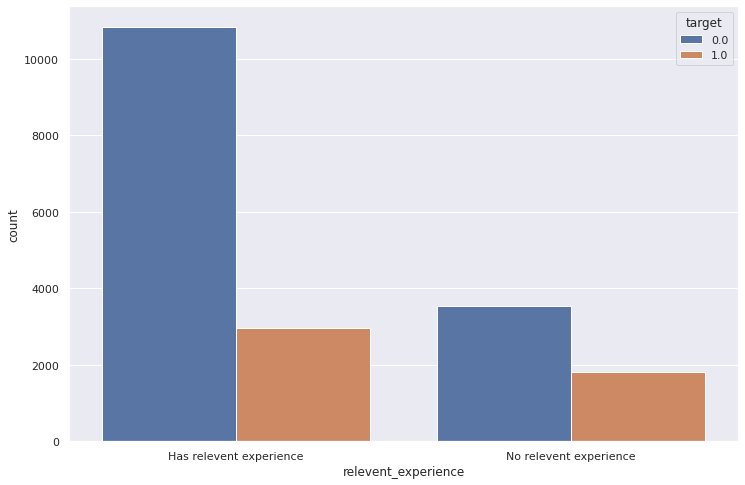

In [21]:
sns.countplot(x=train_data['relevent_experience'], hue='target', data=train_data)

<AxesSubplot:xlabel='city_development_index', ylabel='Count'>

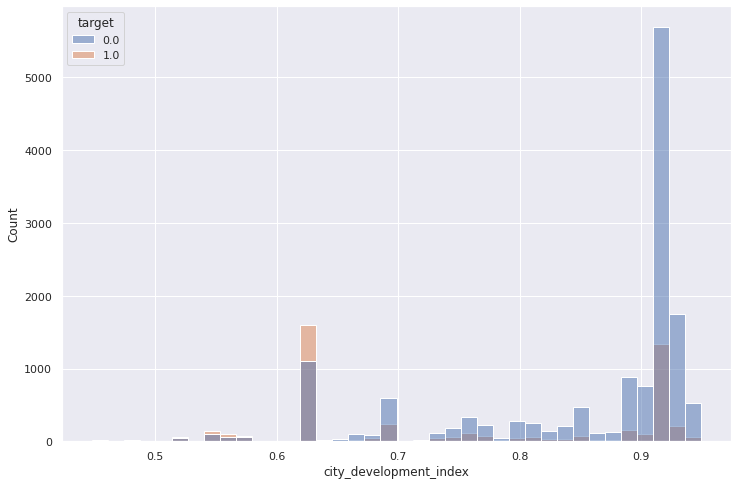

In [20]:
sns.histplot(x=train_data['city_development_index'], hue='target', data=train_data)

<AxesSubplot:xlabel='city', ylabel='Count'>

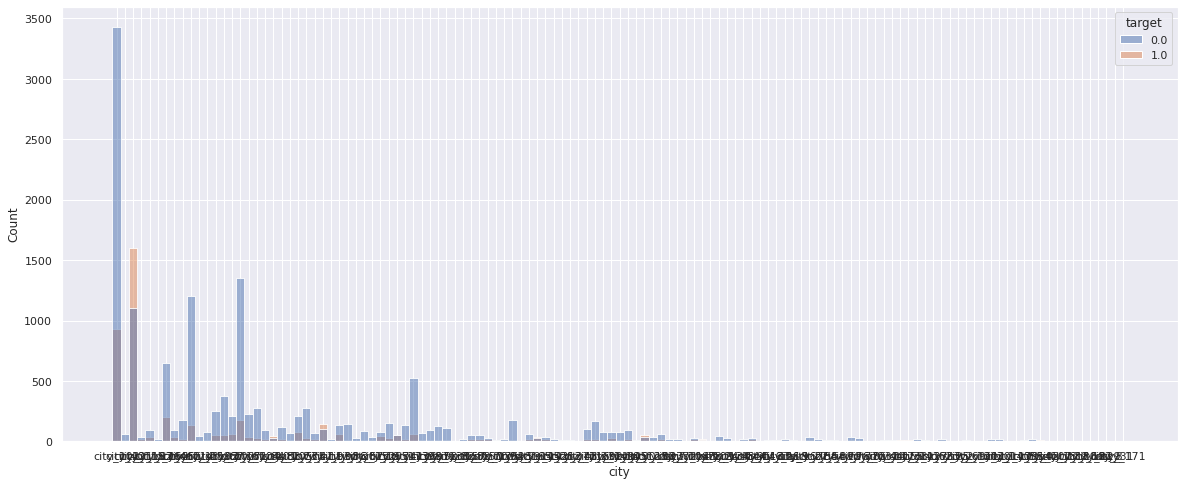

In [22]:
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(x=train_data['city'], hue='target', data=train_data)

**Feature 'City' doesn't really matter, we can remove it.**

<AxesSubplot:xlabel='company_size', ylabel='Count'>

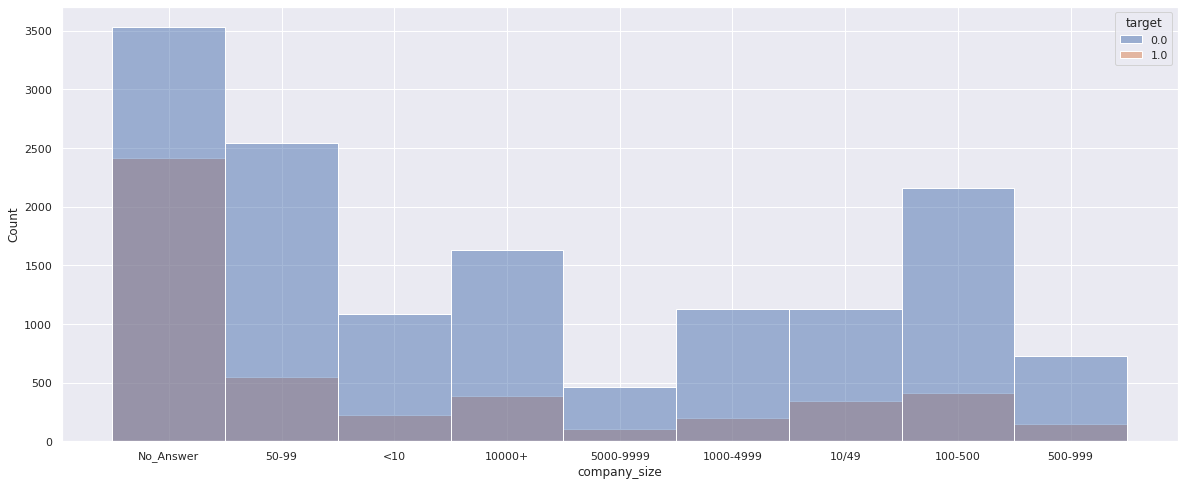

In [23]:
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(x=train_data['company_size'], hue='target', data=train_data)

<AxesSubplot:xlabel='company_type', ylabel='Count'>

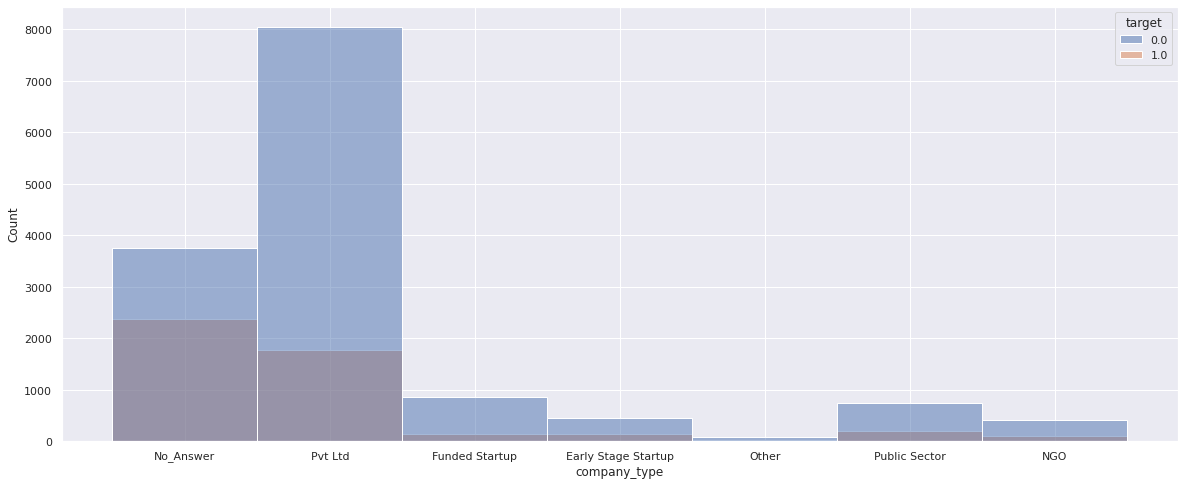

In [24]:
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(x=train_data['company_type'], hue='target', data=train_data)

<AxesSubplot:xlabel='company_type', ylabel='Count'>

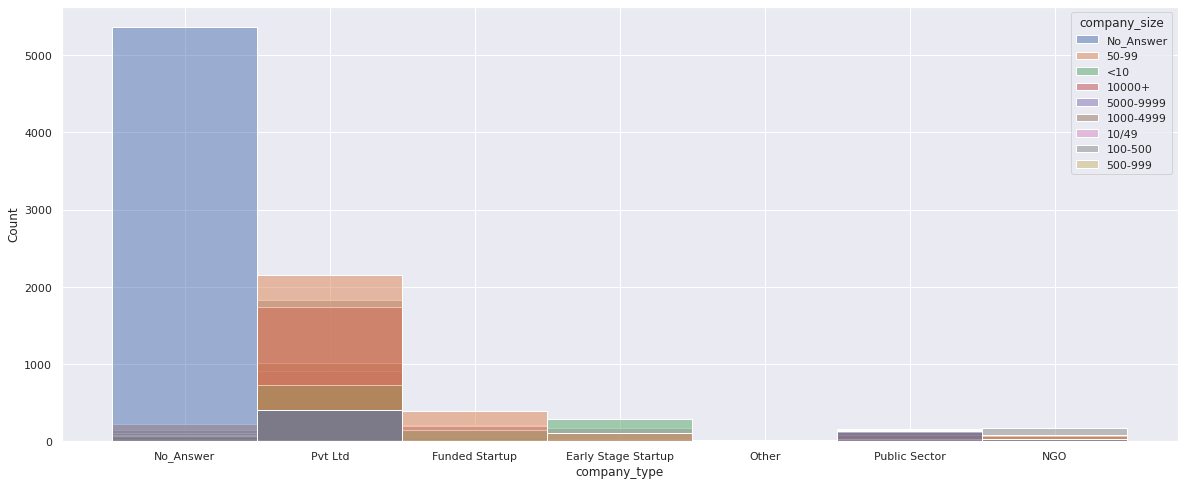

In [25]:
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(x=train_data['company_type'], hue='company_size', data=train_data)

**Features 'company_size' and 'company_type' not informative.
We can drop it too.**

In [26]:
train_data = train_data.drop(['enrollee_id', 'city', 'company_size', 'company_type'],axis=1)
test_data = test_data.drop(['enrollee_id', 'city', 'company_size', 'company_type'],axis=1)

In [27]:
train_data.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,>4,47,0.0
2,0.624,No_Answer,No relevent experience,Full time course,Graduate,STEM,5,never,83,0.0
3,0.789,No_Answer,No relevent experience,No_Answer,Graduate,Business Degree,<1,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,4,8,0.0


In [28]:
test_data.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours
0,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,1,21
1,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,1,98
2,0.624,Male,No relevent experience,no_enrollment,High School,No_Answer,<1,never,15
3,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,1,39
4,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,>4,72


<AxesSubplot:xlabel='last_new_job', ylabel='count'>

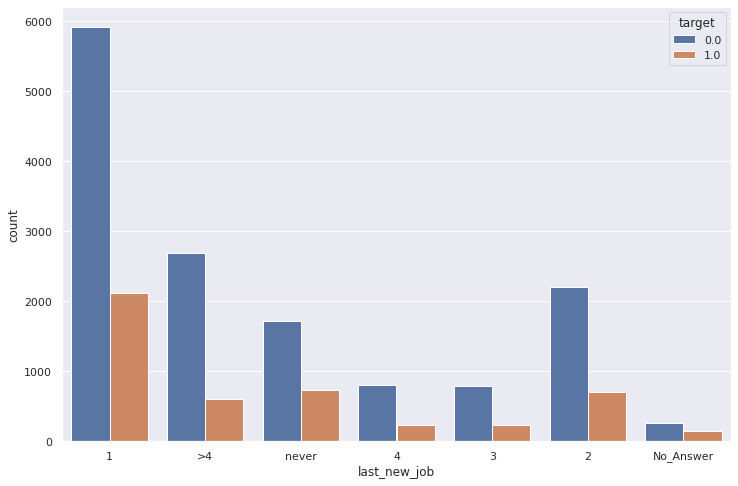

In [29]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train_data['last_new_job'], hue='target', data=train_data)

<AxesSubplot:xlabel='experience', ylabel='count'>

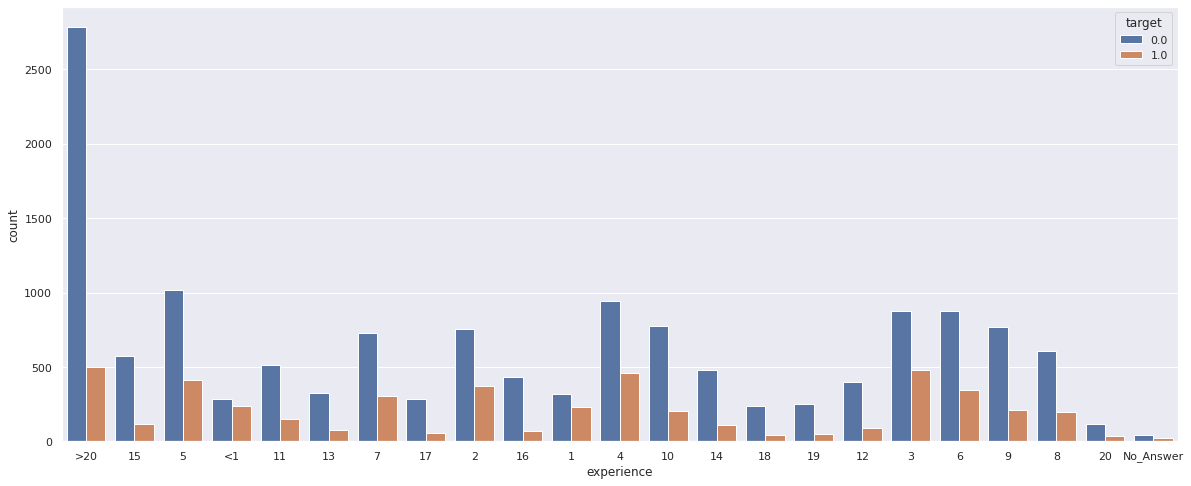

In [30]:
sns.set(rc={'figure.figsize':(20,8)})
sns.countplot(x=train_data['experience'], hue='target', data=train_data)

**We need to correct qualitative data into quantitative**

In [32]:
train_data['last_new_job'] = train_data['last_new_job'].replace({'never':0,'>4':5, 'No_Answer':-1}).astype('float')
test_data['last_new_job'] = test_data['last_new_job'].replace({'never':0,'>4':5, 'No_Answer':-1}).astype('float')
train_data['experience'] = train_data['experience'].replace({'<1':0,'>20':21, 'No_Answer':-1}).astype('float')
test_data['experience'] = test_data['experience'].replace({'<1':0,'>20':21, 'No_Answer':-1}).astype('float')

<AxesSubplot:xlabel='last_new_job', ylabel='count'>

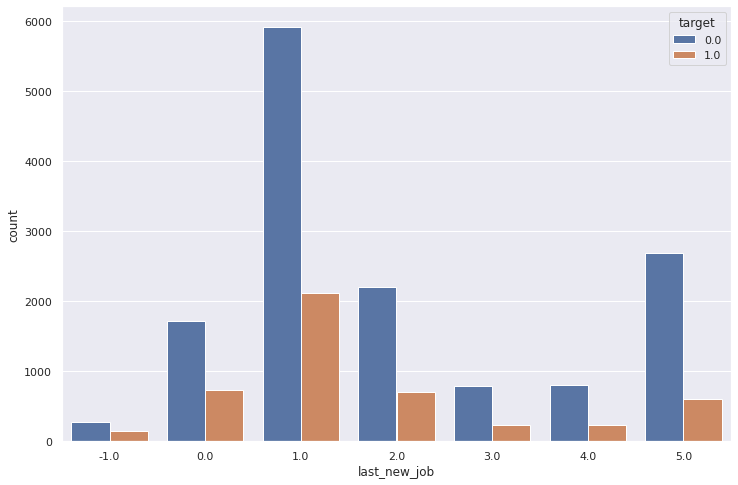

In [33]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train_data['last_new_job'], hue='target', data=train_data)

<AxesSubplot:xlabel='experience', ylabel='count'>

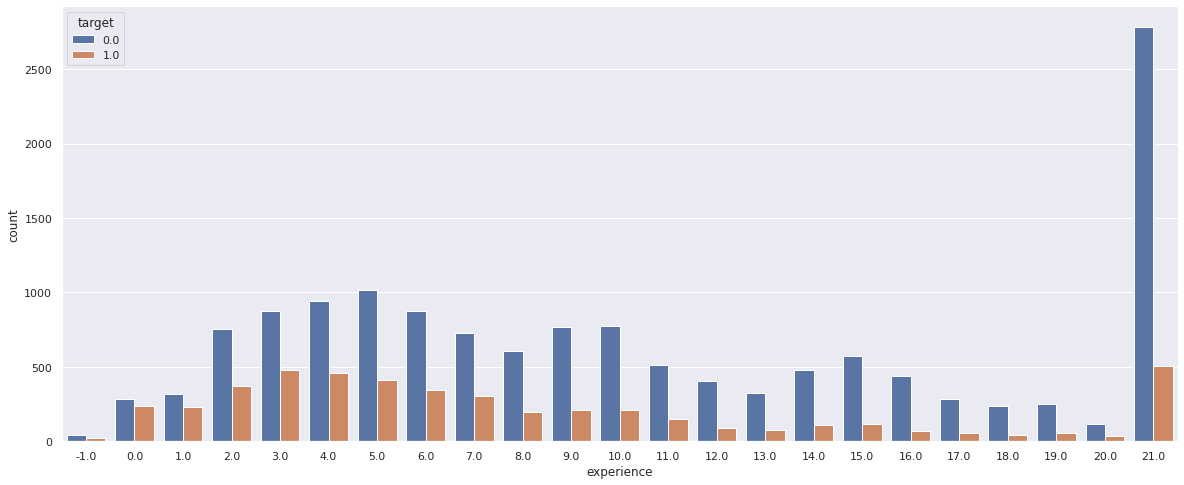

In [34]:
sns.set(rc={'figure.figsize':(20,8)})
sns.countplot(x=train_data['experience'], hue='target', data=train_data)

In [35]:
train_data = pd.get_dummies(train_data, columns=['gender',
                                                 'enrolled_university',
                                                 'relevent_experience',
                                                 'education_level',
                                                 'major_discipline'],drop_first=True)

test_data = pd.get_dummies(test_data, columns=["gender",
                                               "enrolled_university",
                                               "relevent_experience",
                                               "education_level",
                                               "major_discipline"],drop_first=True)

In [36]:
train_data.head()

,city_development_index,experience,last_new_job,training_hours,target,gender_Male,gender_No_Answer,gender_Other,enrolled_university_No_Answer,enrolled_university_Part time course,...,education_level_Masters,education_level_No_Answer,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_No_Answer,major_discipline_Other,major_discipline_STEM
0,0.920,21.0,1.0,36,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.776,15.0,5.0,47,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.624,5.0,0.0,83,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.789,0.0,0.0,52,1.0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0.767,21.0,4.0,8,0.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [37]:
X = train_data.drop("target",axis=1)
y = train_data["target"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)

In [56]:
RF_clf = RandomForestClassifier(n_estimators=50,
                                oob_score=True,
                                random_state=42,
                                verbose=2,
                                max_depth = 10,
                                n_jobs=-1)

In [57]:
RF_clf = RF_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50building tree 6 of 50

building tree 7 of 50
building tree 8 of 50building tree 9 of 50

building tree 10 of 50
building tree 11 of 50building tree 12 of 50building tree 13 of 50


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50building tree 29 of 50

building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50building tree 34 of 50

building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50building tree 43 of 50

building tree 44 of 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [95]:
pred = RF_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [96]:
print(accuracy_score(y_test, pred))

0.7754001391788448


In [97]:
print(confusion_matrix(y_test, pred))

[[3940  351]
 [ 940  517]]


In [98]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4291
         1.0       0.60      0.35      0.44      1457

    accuracy                           0.78      5748
   macro avg       0.70      0.64      0.65      5748
weighted avg       0.75      0.78      0.75      5748



In [99]:
pred = RF_clf.predict(test_data)
result = pd.read_csv("../input/hr-analytics-job-change-of-data-scientists/sample_submission.csv")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [100]:
result.target = pred
result.target.value_counts()

0.0    1789
1.0     340
Name: target, dtype: int64

In [64]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 50)]

max_features = ['auto', 'sqrt', 'log2']

max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}

print(random_grid)

{'n_estimators': [10, 13, 17, 21, 25, 29, 33, 37, 41, 44, 48, 52, 56, 60, 64, 68, 72, 75, 79, 83, 87, 91, 95, 99, 103, 106, 110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157, 161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None]}


In [65]:
rf = RandomForestClassifier(random_state = 42, n_jobs=-1)

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid,
                               n_iter = 100,
                               scoring='neg_mean_absolute_error', 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1,
                               return_train_score=True)

RF_clf_rand = rf_random.fit(X_train, y_train)

best_prms = rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [85]:
print(best_prms)

{'n_estimators': 68, 'max_features': 'sqrt', 'max_depth': 10}


In [86]:
preds = RF_clf_rand.predict(X_test)

In [87]:
print(accuracy_score(y_test, preds))

0.7755741127348643


In [91]:
print(confusion_matrix(y_test, preds))

[[3944  347]
 [ 943  514]]


In [92]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4291
         1.0       0.60      0.35      0.44      1457

    accuracy                           0.78      5748
   macro avg       0.70      0.64      0.65      5748
weighted avg       0.75      0.78      0.75      5748



In [93]:
preds = RF_clf_rand.predict(test_data)
result = pd.read_csv("../input/hr-analytics-job-change-of-data-scientists/sample_submission.csv")

In [94]:
result.target = preds
result.target.value_counts()

0.0    1791
1.0     338
Name: target, dtype: int64